# NYC TAXIS - Predicting Taxi Tip-Rates in NYC

![](taxi.jpg)

# Table of contents
* [Data cleaning](#Datacleaning)
* [Data exploration](#Dataexploration)
* [Data summary](#Datasummary)
* [Model building](#Modelbuilding)
* [Conclusions](#Conclusions)

# Data cleaning <a name="Datacleaning"></a>

This process will mainly involve managing variables that had little or none added value for our research, dealing with outliers and null values, changing formats and generating some interesting information such as the average speed of each trip.

#### Import libraries and set display preferences

In [45]:
import warnings

import pandas as pd
import numpy as np
import math
import datetime
from time import time

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

In [46]:
# Run all you ask in one cell, not only the last required
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#Filter warnings
warnings.filterwarnings('ignore')
#Limit display of decimal places
pd.options.display.float_format = '{:,.4f}'.format

#### Data import

In [47]:
data = pd.read_csv('yellow_tripdata_2019-08.csv')
data.shape
data.head()
data.dtypes

(6073357, 18)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1.0000,2019-08-01 00:09:46,2019-08-01 00:10:36,1.0000,0.0000,1.0000,N,145,145,2.0000,2.5000,0.5000,0.5000,0.0000,0.0000,0.3000,3.8000,0.0000
1,1.0000,2019-08-01 00:30:47,2019-08-01 00:31:39,1.0000,0.0000,1.0000,N,145,145,2.0000,2.5000,0.5000,0.5000,0.0000,0.0000,0.3000,3.8000,0.0000
2,1.0000,2019-08-01 00:44:50,2019-08-01 00:46:32,1.0000,7.1000,1.0000,N,145,145,2.0000,3.0000,0.5000,0.5000,0.0000,0.0000,0.3000,4.3000,0.0000
3,1.0000,2019-08-01 00:57:16,2019-08-01 00:58:20,1.0000,0.0000,1.0000,N,145,145,2.0000,3.0000,0.5000,0.5000,0.0000,0.0000,0.3000,4.3000,0.0000
4,1.0000,2019-08-01 00:59:18,2019-08-01 01:04:13,1.0000,0.0000,1.0000,N,145,145,2.0000,4.5000,0.5000,0.5000,0.0000,0.0000,0.3000,5.8000,0.0000


VendorID                 float64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count          float64
trip_distance            float64
RatecodeID               float64
store_and_fwd_flag        object
PULocationID               int64
DOLocationID               int64
payment_type             float64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
congestion_surcharge     float64
dtype: object

#### Convert some data types to more appropiate ones

In [48]:
data = data.astype({'tpep_pickup_datetime':'datetime64','tpep_dropoff_datetime':'datetime64','RatecodeID':'object','payment_type':'object'})

#### Trip_distance: convert miles to km

In [49]:
def convert_to_km(x):
    conversion_factor = 0.62137119
    return x/conversion_factor

In [50]:
data['trip_distance'] = data['trip_distance'].apply(convert_to_km)

#### Add column for trip duration in minutes

In [51]:
# Add trip duration column
data['trip_duration'] = (data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime']).astype('timedelta64[m]')
data['trip_duration'].describe()

count   6,073,357.0000
mean           17.4935
std            73.4487
min       -17,199.0000
25%             6.0000
50%            11.0000
75%            18.0000
max        36,501.0000
Name: trip_duration, dtype: float64

#### According to the information about the data, the tips column only corresponds to trips that were paid with credit card. For this reason, and since our app will also work with credit card, we will only include trips payed by credit card.

In [52]:
data = data.loc[data['payment_type'] == 1]
data.shape

(4216488, 19)

#### Add column to convert tip_amount to percentage¶

In [53]:
data['tip_percentage'] = ((data['tip_amount'] / data['total_amount'])*100).astype('float64')

#### Drop non useful columns

In [54]:
data.describe()

,VendorID,passenger_count,trip_distance,PULocationID,DOLocationID,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,trip_duration,tip_percentage
count,"4,216,488.0000","4,216,488.0000","4,216,488.0000","4,216,488.0000","4,216,488.0000","4,216,488.0000","4,216,488.0000","4,216,488.0000","4,216,488.0000","4,216,488.0000","4,216,488.0000","4,216,488.0000","4,216,488.0000","4,216,488.0000","4,215,899.0000"
mean,1.6438,1.5530,5.0887,162.4672,160.4551,13.7269,1.1800,0.4967,3.1205,0.4477,0.2999,20.7782,2.3300,17.2086,14.9016
std,0.4792,1.2026,6.5564,65.1178,69.6434,12.7841,1.2763,0.0422,3.1041,1.7751,0.0060,16.1469,0.6293,68.7692,5.3215
min,1.0000,0.0000,0.0000,1.0000,1.0000,-31.0000,-21.2200,-0.5000,-51.9300,-6.1200,-0.3000,-93.3500,-2.5000,"-17,199.0000",0.0000
25%,1.0000,1.0000,1.6576,114.0000,107.0000,6.5000,0.0000,0.5000,1.7500,0.0000,0.3000,12.3000,2.5000,6.0000,13.0435
50%,2.0000,1.0000,2.7842,162.0000,162.0000,9.5000,0.5000,0.5000,2.3600,0.0000,0.3000,15.3600,2.5000,11.0000,16.6611
75%,2.0000,2.0000,5.1499,231.0000,233.0000,15.0000,2.5000,0.5000,3.4600,0.0000,0.3000,21.9500,2.5000,18.0000,16.6667
max,4.0000,9.0000,968.1814,265.0000,265.0000,950.0000,17.5000,24.5200,537.0000,150.0000,0.3000,960.8000,2.7500,"7,283.0000",99.8539


| Variable | Reason for drop |
| :--- | :--- | 
| vendor_ID | Irrelevant | 
| store_and_fwd_flag | Irrelevant | 
| congestion_surcharge | Irrelevant | 
| payment_type | Fixed value | 
| tolls_amount | 75% of values = 0 | 
| mta_tax | Minimal standard deviation, practically fixed value | 
| improvement_surcharge | Minimal standard deviation, practically fixed value | 
| RatecodeID | 75% of the values practically identical to the mean | 
| total_amount | Equals the sum of all variables in the trip | 

In [55]:
data.drop(['VendorID','store_and_fwd_flag','congestion_surcharge','payment_type','tolls_amount','mta_tax','improvement_surcharge','RatecodeID','total_amount'], axis=1, inplace=True)
data.dtypes

tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
PULocationID                      int64
DOLocationID                      int64
fare_amount                     float64
extra                           float64
tip_amount                      float64
trip_duration                   float64
tip_percentage                  float64
dtype: object

#### Erase values that do not correspond to year 2019 and month August.

In [56]:
data = data.loc[(data['tpep_pickup_datetime'].dt.year == 2019) & (data['tpep_pickup_datetime'].dt.month == 8)]
data = data.loc[(data['tpep_dropoff_datetime'].dt.year == 2019) & (data['tpep_dropoff_datetime'].dt.month == 8)]
data.shape

(4214783, 11)

#### Remove all trips where the recorded distance, fare amount, total amount or passenger count were 0, and the trips with a time duration less or equal to 0.

In [57]:
data = data.loc[(data['trip_distance'] != 0) & (data['fare_amount'] != 0) & (data['passenger_count'] != 0) & (data['trip_duration'] > 0)]
data.shape

(4090903, 11)

#### Add column for average trip speed (we are going to assume that if it is lower then 40km/h it took too long).

In [58]:
data['trip_average_speed'] = (data['trip_distance'] / (data['trip_duration']/60)).astype('float64')

#### Add column to check the part of the day in which the trip has been made.

In [59]:
data['pickup_time'],data['pickup_date']= data['tpep_pickup_datetime'].apply(lambda x:x.time()), data['tpep_pickup_datetime'].apply(lambda x:x.date())

In [60]:
def day_part(x):
    if datetime.time(6,0,0) < x < datetime.time(11, 29, 59):
        return 'Morning'
    elif datetime.time(11, 30, 0) < x < datetime.time(14, 29, 59):
        return 'Midday'
    elif datetime.time(14, 30, 0) < x < datetime.time(17, 59, 59):
        return 'Afternoon'
    elif datetime.time(18, 0, 0) < x < datetime.time(20, 59, 59):
        return 'Evening'
    else:
        return 'Night'

In [61]:
data['day_part'] = data['pickup_time'].apply(day_part)

#### Add column to check if the trip was made on a weekday or weekend.

In [62]:
def weekday(x):
    if datetime.datetime.weekday(x) == 1 :
        return 'Monday'
    elif datetime.datetime.weekday(x) == 2 :
        return 'Tuesday'
    elif datetime.datetime.weekday(x) == 3 :
        return 'Wednesday'
    elif datetime.datetime.weekday(x) == 4 :
        return 'Thursday'
    elif datetime.datetime.weekday(x) == 5 :
        return 'Friday'
    elif datetime.datetime.weekday(x) == 6 :
        return 'Saturday'
    else:
        return 'Sunday'

In [63]:
data['weekday'] = data['tpep_pickup_datetime'].apply(weekday)

In [64]:
data.dtypes

tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
PULocationID                      int64
DOLocationID                      int64
fare_amount                     float64
extra                           float64
tip_amount                      float64
trip_duration                   float64
tip_percentage                  float64
trip_average_speed              float64
pickup_time                      object
pickup_date                      object
day_part                         object
weekday                          object
dtype: object

#### Add additional column to categorise passenger load.

In [65]:
def encode_passenger(x):
    if x == 1.00:
        return 'Individual passenger'
    elif (x == 2.00) | (x==3.00):
        return 'Small group'
    else:
        return 'Big group'

In [66]:
data['passenger_load'] = list(map(encode_passenger, data['passenger_count']))

#### NaN values - no need to deal with them

In [67]:
data.isnull().sum()

tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
PULocationID             0
DOLocationID             0
fare_amount              0
extra                    0
tip_amount               0
trip_duration            0
tip_percentage           0
trip_average_speed       0
pickup_time              0
pickup_date              0
day_part                 0
weekday                  0
passenger_load           0
dtype: int64

#### Remove datetime variables as we have converted them into categories to analyse our data

In [68]:
data.drop(['tpep_pickup_datetime','tpep_dropoff_datetime','pickup_time','pickup_date'], axis=1, inplace=True)
data.dtypes

passenger_count       float64
trip_distance         float64
PULocationID            int64
DOLocationID            int64
fare_amount           float64
extra                 float64
tip_amount            float64
trip_duration         float64
tip_percentage        float64
trip_average_speed    float64
day_part               object
weekday                object
passenger_load         object
dtype: object

In [69]:
data.head()

,passenger_count,trip_distance,PULocationID,DOLocationID,fare_amount,extra,tip_amount,trip_duration,tip_percentage,trip_average_speed,day_part,weekday,passenger_load
5,1.0000,11.7482,234,61,28.0000,3.0000,7.9500,34.0000,20.0000,20.7321,Night,Wednesday,Individual passenger
9,1.0000,10.4607,90,7,25.0000,3.0000,4.3200,31.0000,13.0435,20.2466,Night,Wednesday,Individual passenger
10,1.0000,3.3796,164,79,9.5000,3.0000,2.0000,11.0000,13.0719,18.4343,Night,Wednesday,Individual passenger
11,1.0000,0.9978,13,13,4.5000,0.5000,2.4900,2.0000,23.0769,29.9338,Night,Wednesday,Individual passenger
15,1.0000,2.8968,163,68,9.5000,3.0000,2.6500,11.0000,16.6144,15.8008,Night,Wednesday,Individual passenger


# Data exploration <a name="Dataexploration"></a>

In this section we will deal with the distribution of the variables taking a closer look to outliers. 

### Numerical variables

#### Exploration of the variables

In [70]:
numerical = data.select_dtypes(np.number)
numerical.describe()

,passenger_count,trip_distance,PULocationID,DOLocationID,fare_amount,extra,tip_amount,trip_duration,tip_percentage,trip_average_speed
count,"4,090,903.0000","4,090,903.0000","4,090,903.0000","4,090,903.0000","4,090,903.0000","4,090,903.0000","4,090,903.0000","4,090,903.0000","4,090,903.0000","4,090,903.0000"
mean,1.5840,5.1463,162.5036,160.3497,13.4394,1.1621,3.0978,17.2213,14.9544,20.4115
std,1.1976,6.5504,64.9768,69.5100,12.0149,1.2670,2.9393,68.0734,5.1232,12.8131
min,1.0000,0.0161,1.0000,1.0000,-31.0000,-21.2200,-51.9300,1.0000,0.0000,0.0007
25%,1.0000,1.7220,114.0000,107.0000,6.5000,0.0000,1.7600,7.0000,13.0435,13.3116
50%,1.0000,2.8324,162.0000,162.0000,9.5000,0.5000,2.3600,11.0000,16.6621,17.9327
75%,2.0000,5.2304,231.0000,233.0000,15.0000,2.5000,3.4600,18.0000,16.6667,24.5264
max,9.0000,493.9077,265.0000,265.0000,950.0000,17.5000,500.0000,"7,283.0000",99.5591,"4,557.6622"


#### Remove negative sign from values.

In [71]:
numerical = abs(numerical)
numerical.describe()

,passenger_count,trip_distance,PULocationID,DOLocationID,fare_amount,extra,tip_amount,trip_duration,tip_percentage,trip_average_speed
count,"4,090,903.0000","4,090,903.0000","4,090,903.0000","4,090,903.0000","4,090,903.0000","4,090,903.0000","4,090,903.0000","4,090,903.0000","4,090,903.0000","4,090,903.0000"
mean,1.5840,5.1463,162.5036,160.3497,13.4395,1.1621,3.0979,17.2213,14.9544,20.4115
std,1.1976,6.5504,64.9768,69.5100,12.0148,1.2670,2.9393,68.0734,5.1232,12.8131
min,1.0000,0.0161,1.0000,1.0000,0.0100,0.0000,0.0000,1.0000,0.0000,0.0007
25%,1.0000,1.7220,114.0000,107.0000,6.5000,0.0000,1.7600,7.0000,13.0435,13.3116
50%,1.0000,2.8324,162.0000,162.0000,9.5000,0.5000,2.3600,11.0000,16.6621,17.9327
75%,2.0000,5.2304,231.0000,233.0000,15.0000,2.5000,3.4600,18.0000,16.6667,24.5264
max,9.0000,493.9077,265.0000,265.0000,950.0000,21.2200,500.0000,"7,283.0000",99.5591,"4,557.6622"


#### Explore data distribution accross the variables

Text(0.5, 0.98, 'Distribution of numerical variables')

<AxesSubplot:xlabel='passenger_count'>

<AxesSubplot:xlabel='trip_distance'>

<AxesSubplot:xlabel='fare_amount'>

<AxesSubplot:xlabel='extra'>

<AxesSubplot:xlabel='tip_amount'>

<AxesSubplot:xlabel='trip_duration'>

<AxesSubplot:xlabel='trip_average_speed'>

<AxesSubplot:xlabel='PULocationID'>

<AxesSubplot:xlabel='DOLocationID'>

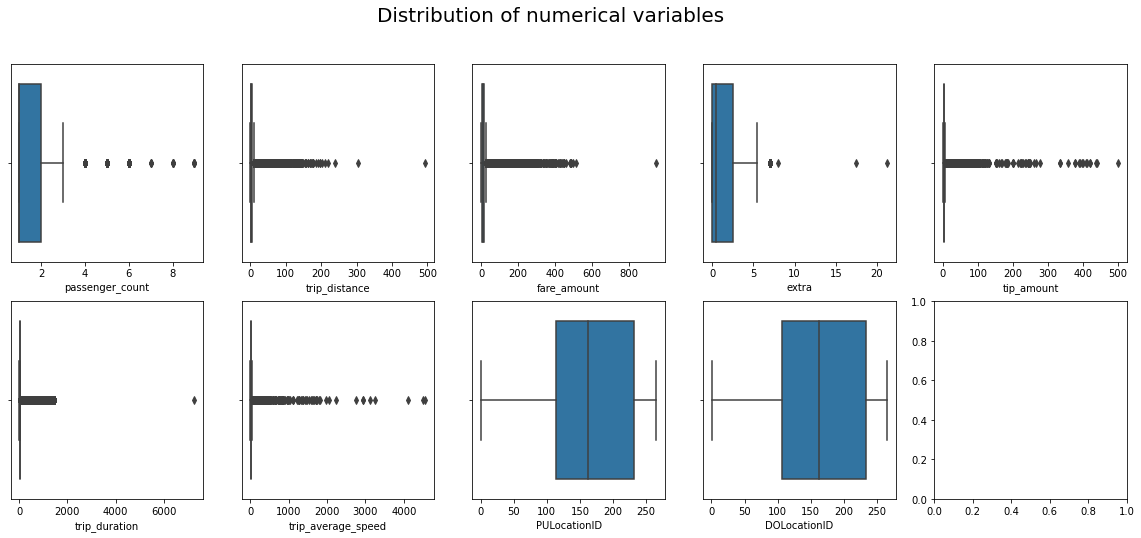

In [72]:
fig, axes = plt.subplots(2,5,  figsize=(20, 8))
fig.suptitle('Distribution of numerical variables',fontsize =20)
sns.boxplot(ax=axes[0,0],data= numerical, x='passenger_count')
sns.boxplot(ax=axes[0,1],data= numerical, x= 'trip_distance')
sns.boxplot(ax=axes[0,2],data= numerical, x= 'fare_amount')
sns.boxplot(ax=axes[0,3],data= numerical, x= 'extra')
sns.boxplot(ax=axes[0,4],data= numerical, x= 'tip_amount')
sns.boxplot(ax=axes[1,0],data= numerical, x= 'trip_duration')
sns.boxplot(ax=axes[1,1],data= numerical, x= 'trip_average_speed')
sns.boxplot(ax=axes[1,2],data= numerical, x= 'PULocationID')
sns.boxplot(ax=axes[1,3],data= numerical, x= 'DOLocationID')


#### Dealing with outliers
Instead of removing outliers based on their statistical behaviour, we have decided to work with certain thresholds considered to be within the limit of a normal behaviour in some variables.

In [73]:
numerical = numerical.loc[(numerical['trip_distance'] <100) & 
                          (numerical['fare_amount'] <100) & 
                          (numerical['tip_amount']<30)&
                          (numerical['trip_duration'] <120) & 
                          (numerical['trip_average_speed'] <120)]
numerical.shape

(4075772, 10)

Text(0.5, 0.98, 'Distribution of numerical variables')

<AxesSubplot:xlabel='passenger_count'>

<AxesSubplot:xlabel='trip_distance'>

<AxesSubplot:xlabel='fare_amount'>

<AxesSubplot:xlabel='extra'>

<AxesSubplot:xlabel='tip_amount'>

<AxesSubplot:xlabel='trip_duration'>

<AxesSubplot:xlabel='trip_average_speed'>

<AxesSubplot:xlabel='PULocationID'>

<AxesSubplot:xlabel='DOLocationID'>

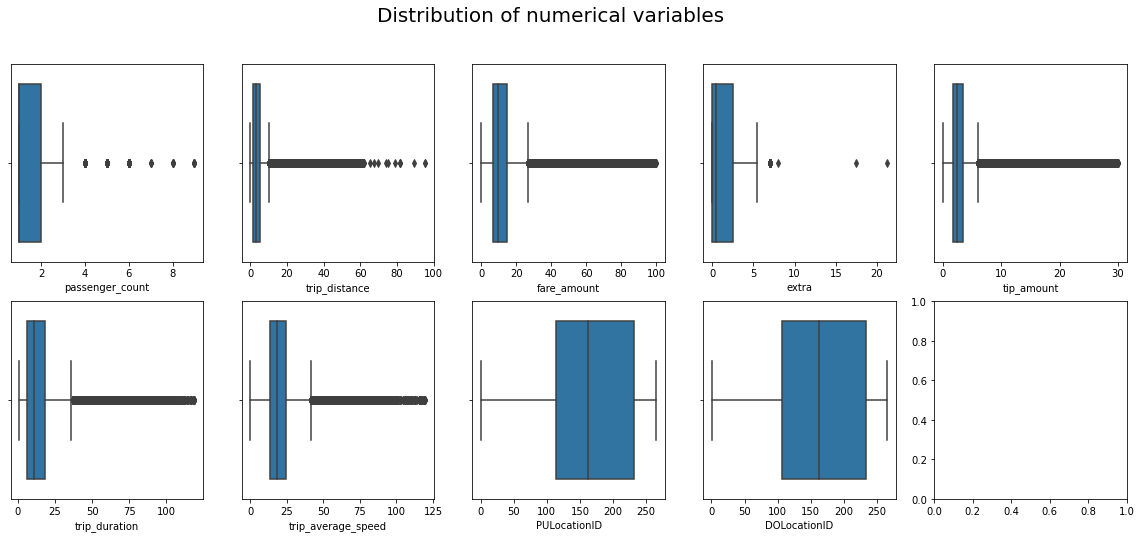

In [74]:
fig, axes = plt.subplots(2,5,  figsize=(20, 8))
fig.suptitle('Distribution of numerical variables',fontsize =20)
sns.boxplot(ax=axes[0,0],data= numerical, x='passenger_count')
sns.boxplot(ax=axes[0,1],data= numerical, x= 'trip_distance')
sns.boxplot(ax=axes[0,2],data= numerical, x= 'fare_amount')
sns.boxplot(ax=axes[0,3],data= numerical, x= 'extra')
sns.boxplot(ax=axes[0,4],data= numerical, x= 'tip_amount')
sns.boxplot(ax=axes[1,0],data= numerical, x= 'trip_duration')
sns.boxplot(ax=axes[1,1],data= numerical, x= 'trip_average_speed')
sns.boxplot(ax=axes[1,2],data= numerical, x= 'PULocationID')
sns.boxplot(ax=axes[1,3],data= numerical, x= 'DOLocationID')


#### Merge numerical with categorical variables again

In [75]:
categorical = data.select_dtypes(object)
numerical.reset_index(drop=True, inplace=True)
categorical.reset_index(drop=True, inplace=True)
merged_data = pd.merge(numerical,categorical,left_index=True, right_index=True)
merged_data.shape
merged_data.head()

(4075772, 13)

,passenger_count,trip_distance,PULocationID,DOLocationID,fare_amount,extra,tip_amount,trip_duration,tip_percentage,trip_average_speed,day_part,weekday,passenger_load
0,1.0000,11.7482,234,61,28.0000,3.0000,7.9500,34.0000,20.0000,20.7321,Night,Wednesday,Individual passenger
1,1.0000,10.4607,90,7,25.0000,3.0000,4.3200,31.0000,13.0435,20.2466,Night,Wednesday,Individual passenger
2,1.0000,3.3796,164,79,9.5000,3.0000,2.0000,11.0000,13.0719,18.4343,Night,Wednesday,Individual passenger
3,1.0000,0.9978,13,13,4.5000,0.5000,2.4900,2.0000,23.0769,29.9338,Night,Wednesday,Individual passenger
4,1.0000,2.8968,163,68,9.5000,3.0000,2.6500,11.0000,16.6144,15.8008,Night,Wednesday,Individual passenger


## DATA SUMMARY <a name="Datasummary"></a>

In order to better understand the behaviour of our dataset against our target variable (tip_amount) we are going to create some visualizations to summarise it. 

#### Export data for visualization purposes in Tableau

In [76]:
# data_visual = merged_data.sample(n=100000, random_state=1)
# data_visual.shape
# data_visual.to_csv('taxi_visual.csv', index = False)

#### Get a first overview of the data to select the most appropiate graphs for the summary

In [77]:
merged_data.drop(['tip_percentage'],axis=1, inplace=True)

In [78]:
merged_data.dtypes
merged_data.describe()
merged_data[['day_part','weekday','passenger_load']].describe()

passenger_count       float64
trip_distance         float64
PULocationID            int64
DOLocationID            int64
fare_amount           float64
extra                 float64
tip_amount            float64
trip_duration         float64
trip_average_speed    float64
day_part               object
weekday                object
passenger_load         object
dtype: object

,passenger_count,trip_distance,PULocationID,DOLocationID,fare_amount,extra,tip_amount,trip_duration,trip_average_speed
count,"4,075,772.0000","4,075,772.0000","4,075,772.0000","4,075,772.0000","4,075,772.0000","4,075,772.0000","4,075,772.0000","4,075,772.0000","4,075,772.0000"
mean,1.5834,5.0942,162.5367,160.3052,13.3014,1.1650,3.0693,13.8892,20.3926
std,1.1969,6.3386,64.9917,69.4518,11.2078,1.2677,2.5708,11.0371,10.5380
min,1.0000,0.0161,1.0000,1.0000,0.0100,0.0000,0.0000,1.0000,0.0098
25%,1.0000,1.7059,114.0000,107.0000,6.5000,0.0000,1.7600,6.0000,13.3576
50%,1.0000,2.8324,162.0000,162.0000,9.5000,0.5000,2.3600,11.0000,17.9327
75%,2.0000,5.1982,231.0000,233.0000,14.5000,2.5000,3.4600,18.0000,24.5264
max,9.0000,95.4341,265.0000,265.0000,99.9900,21.2200,29.9800,119.0000,119.7352


,day_part,weekday,passenger_load
count,4075772,4075772,4075772
unique,5,7,3
top,Night,Wednesday,Individual passenger
freq,1002090,766308,2933439


#### Distribution of trips across the week and day times

<Figure size 1120x420 with 0 Axes>

Text(0.5, 1.0, 'Distribution of trips across the week')

[Text(0.5, 31.805555555555554, ''), Text(119.30555555555557, 0.5, '')]

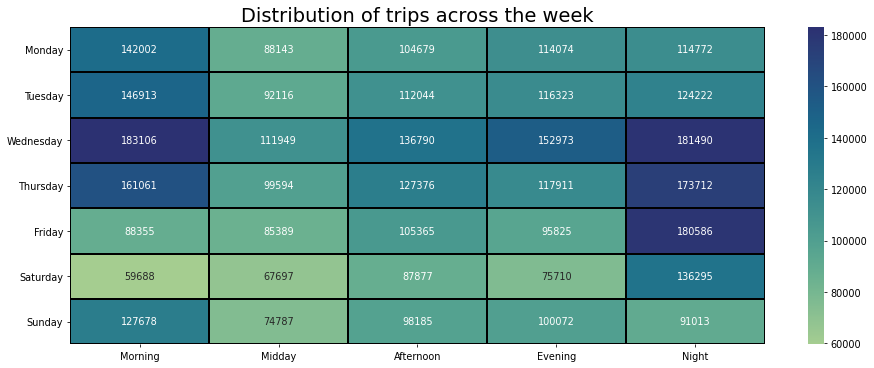

In [79]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_parts = ['Morning', 'Midday', 'Afternoon', 'Evening', 'Night']
cross = pd.crosstab(merged_data['weekday'], merged_data['day_part'], margins = False).reindex(days,day_parts)
plt.figure(figsize= (16, 6), dpi= 70)
plt.title("Distribution of trips across the week", fontsize =20)
trip_distribution = sns.heatmap(cross, cmap='crest', annot=True, fmt='g',linewidths=1, linecolor="k")
trip_distribution.set( xlabel="", ylabel="",)
# sns.set(font_scale=1) # set fontsize 2

Most trips are concentrated in the morning and night times. Wednesdays, Thursdays and Fridays are the days with greater business. The color gradient used to identify the slots makes the identification of hight demand hours very easy.

#### Distribution of tip amounts

<Figure size 1152x432 with 0 Axes>

Text(0.5, 1.0, 'Distribution of tip amounts')

[Text(0.5, 0, 'Tip amount'), Text(0, 0.5, '')]

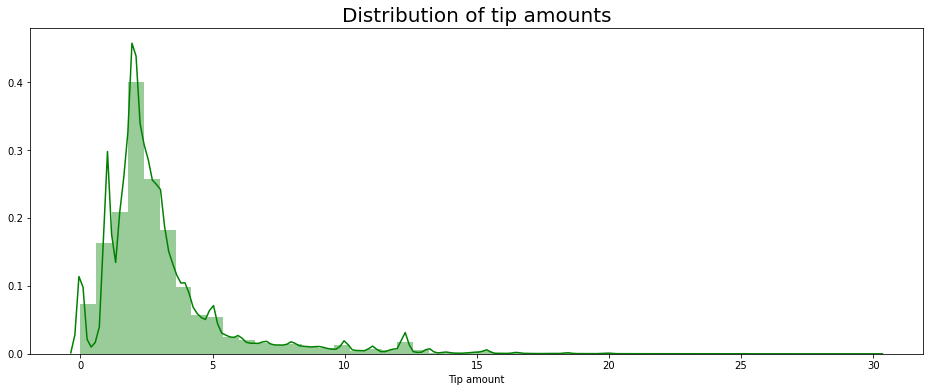

In [80]:
plt.figure(figsize=(16, 6))
plt.title("Distribution of tip amounts", fontsize =20)
tip_distribution = sns.distplot(merged_data['tip_amount'],color="g")
tip_distribution.set( xlabel="Tip amount", ylabel="",)

Clear positive asymmetry. Although the majority of values occurs in the left portion of the distribution, it is the tail of the distribution, extending to the right and containing extremely large values, that determines the skewness of the distribution. Spread peaks indicating a fixed tip value (eg. \\$0, \\$2, \\$3, \\$5, \\$10...). 

#### Correlation matrix to find significant variables for our target variable

<Figure size 1120x420 with 0 Axes>

Text(0.5, 1.0, 'Correlation matrix')

<AxesSubplot:title={'center':'Correlation matrix'}>

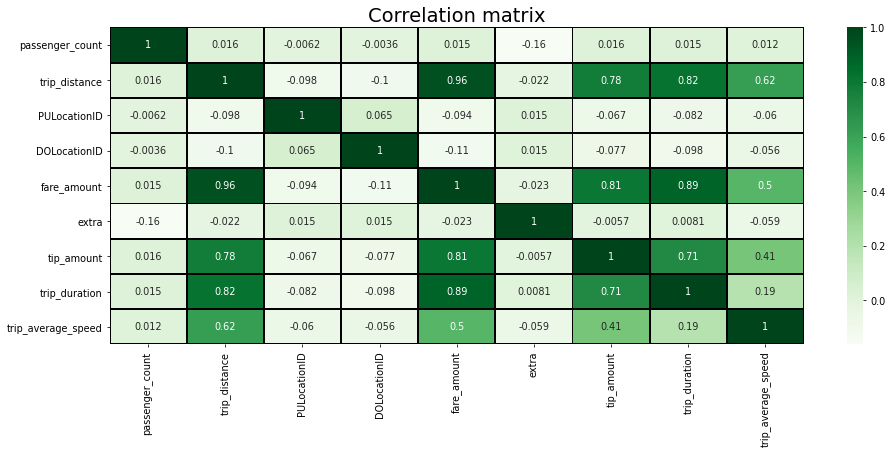

In [81]:
plt.figure(figsize= (16, 6), dpi= 70)
plt.title("Correlation matrix", fontsize =20)
corr_matrix = merged_data.corr()
sns.heatmap(corr_matrix, annot=True, cmap= 'Greens',linewidths=1, linecolor="k")

Given their little power to predict out target variable (tip_amount) some variables will be removed.

In [82]:
merged_data.drop(['PULocationID','DOLocationID','extra'],axis=1, inplace=True)
merged_data.shape

(4075772, 9)

#### Correlation among main variables and distribution plots

<Figure size 1152x432 with 0 Axes>

<Figure size 1152x432 with 0 Axes>

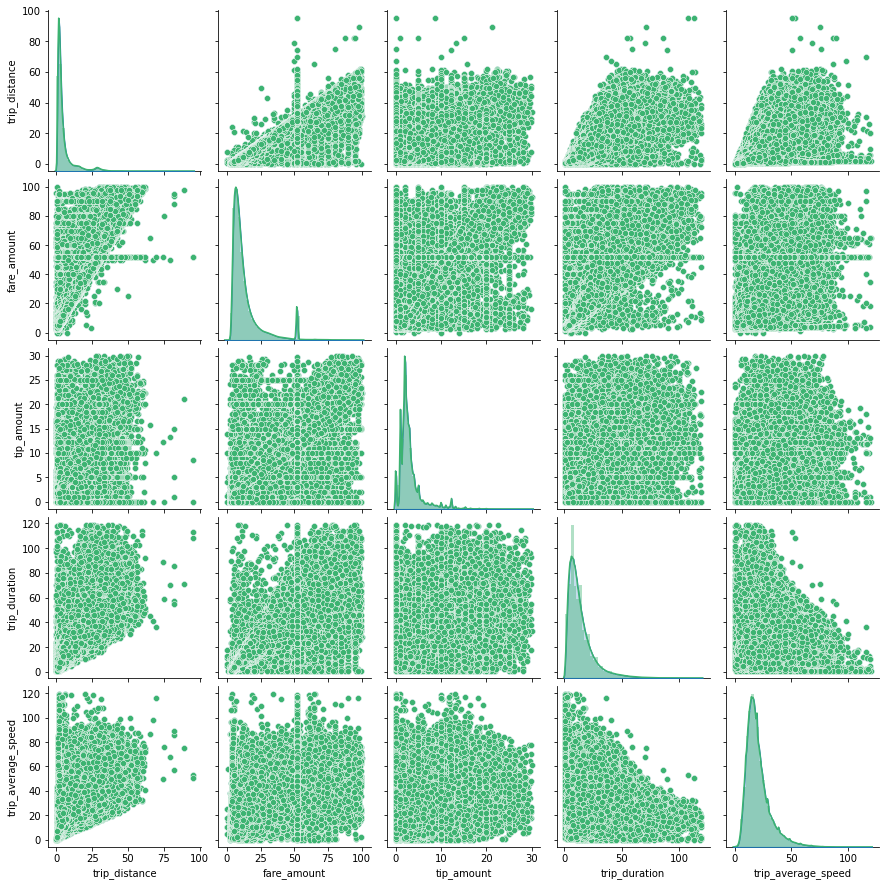

In [83]:
plt.figure(figsize=(16, 6))
g = sns.pairplot(merged_data[['trip_distance','fare_amount','tip_amount','trip_duration','trip_average_speed']],diag_kind="kde")
g.map_upper(sns.scatterplot,color='mediumseagreen')
g.map_lower(sns.scatterplot, color='mediumseagreen')
g.map_diag(sns.distplot, color='mediumseagreen')

There's a linear relationship between tip amount and fare amount, trip duration and trip distance. Some values that appear repetitively regardless of the trend correspond to fixed amounts (eg. \\$50 in fare amount, or \\$5, \\$10 or \\$15 in tip amount). All variables have an assymetric distribution, showing that cases concentrate towards the left of the distribution.

## MODEL BUILDING <a name="Modelbuilding"></a>

In [84]:
model_data = merged_data

#### Model traning, fitting and validation

In [85]:
# separate x/y
y = model_data['tip_amount']
X= model_data.drop(['tip_amount'], axis=1)
# Splitting into train set and test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)
# TRAIN DATASET
# numerical
numerical_train = X_train.select_dtypes(include = np.number)
transformer = StandardScaler().fit(numerical_train)
num_standardized = transformer.transform(numerical_train)
train_num_stand = pd.DataFrame(num_standardized, columns=numerical_train.columns)
# categorical
categorical_train = X_train.select_dtypes(include = np.object)
encoder = OneHotEncoder().fit(categorical_train)
train_onehot = encoder.transform(categorical_train).toarray()
enc = [columname for sublist in encoder.categories_ for columname in sublist]
train_onehot = pd.DataFrame(train_onehot,columns=enc)
# final train dataset
X_train_preproc = pd.concat([train_num_stand,train_onehot], axis= 1)

# TEST DATASET
# numerical
numerical_test = X_test.select_dtypes(include = np.number)
test_num_standardized = transformer.transform(numerical_test)
test_num_stand = pd.DataFrame(test_num_standardized, columns=numerical_test.columns)
# categorical
categorical_test = X_test.select_dtypes(include = np.object)
test_onehot = encoder.transform(categorical_test).toarray()
enc = [columname for sublist in encoder.categories_ for columname in sublist]
test_onehot = pd.DataFrame(test_onehot,columns=enc)
# final test dataset
X_test_preproc = pd.concat([test_num_stand,test_onehot], axis= 1)

In [86]:
model1 = DecisionTreeRegressor()
model2 = LinearRegression()

model_pipeline = [model1, model2]

train_score = []
test_score = []
cross_scores = []
mse = []
rmse = []

for model in model_pipeline:
    model.fit(X_train_preproc,y_train)
    
    test_score.append(model.score(X_test_preproc, y_test))
    mse_calculated = mean_squared_error(y_test,model.predict(X_test_preproc))
    rmse.append(math.sqrt(mse_calculated))
    print("Validation metrics done!")

DecisionTreeRegressor()

Validation metrics done!


LinearRegression()

Validation metrics done!


In [87]:
summary = {'Test Score':test_score,'rmse':rmse,}
summary = pd.DataFrame(summary).T
summary.columns = 'DecisionTree', 'LinearRegression'

In [88]:
summary

,DecisionTree,LinearRegression
Test Score,0.3481,0.6536
rmse,2.0740,1.5118


## CONCLUSIONS <a name="Conclusions"></a>

Due to a large amount of data (+4 million trips) and the current computational power of our machines only two regression algorithms could be tested. Out of both, linear regression is the one providing a higher accuracy of 0.65. Nevertheless, this score means that the variance between our values can only be explained to a certain point. When the model gives us a tipping amount, it is telling us is that only 65% per cent of the passengers taking that same trip agree that that should be the tip amount. Thus, the RMSE score is high (1.5) suggesting our model cannot predict data very accurately.

To improve the model, we could add further data spread across a wider timeline. Still, problems such as tipping (which is a very subjective issue, everybody tips differently) or liking a certain product, are things that can only be predicted to a certain extent because there is no universal consensus about it.

The exploratory analysis has uncovered some insights that can be beneficial for our business. In more affluent parts of the city and during peak hours, a higher percentage tip will be paid to any taxi driver. Given the fact that there is a good relationship between distance, duration and tip amount, we could use this information to identify bonus areas and create a reward system for our best drivers by sending them to work in those areas more often. 

#### Turning the model into an API (coming soon)